# Benchmark Optimization Functions Using Genetic Algorithms

This notebook implements the solution for optimizing benchmark functions using Genetic Algorithms. The implementation includes:

1. Two selected multimodal optimization functions
2. Function visualization (2D contour and 3D surface plots)
3. Genetic Algorithm implementation with:
   - Binary and real-valued encoding
   - Multiple crossover types
   - Configurable parameters
4. Optimization experiments
5. Statistical analysis of results


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from typing import Tuple, List, Callable
import random
from scipy import stats
import pandas as pd

# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)


## 1. Function Selection and Implementation
 
 We'll implement two popular multimodal benchmark functions:
 
 1. **Rastrigin Function**:
    - Domain: $x, y \in [-5.12, 5.12]$
    - Formula: $f_1(x,y) = 20 + (x^2 - 10\cos(2\pi x)) + (y^2 - 10\cos(2\pi y))$
    - Global minimum: $f_1(0,0) = 0$
 
 2. **Ackley Function**:
    - Domain: $x, y \in [-5, 5]$
    - Formula: $f_2(x,y) = -20\exp(-0.2\sqrt{0.5(x^2 + y^2)}) - \exp(0.5(\cos(2\pi x) + \cos(2\pi y))) + e + 20$
    - Global minimum: $f_2(0,0) = 0$

In [2]:
def rastrigin(x: float, y: float) -> float:
    """
    Rastrigin function implementation.
    Domain: x, y ∈ [-5.12, 5.12]
    Global minimum: f(0,0) = 0
    """
    return 20 + (x**2 - 10*np.cos(2*np.pi*x)) + (y**2 - 10*np.cos(2*np.pi*y))

def ackley(x: float, y: float) -> float:
    """
    Ackley function implementation.
    Domain: x, y ∈ [-5, 5]
    Global minimum: f(0,0) = 0
    """
    term1 = -20 * np.exp(-0.2 * np.sqrt(0.5 * (x**2 + y**2)))
    term2 = -np.exp(0.5 * (np.cos(2*np.pi*x) + np.cos(2*np.pi*y)))
    return term1 + term2 + np.e + 20

# Define domains
RASTRIGIN_DOMAIN = (-5.12, 5.12)
ACKLEY_DOMAIN = (-5.0, 5.0)


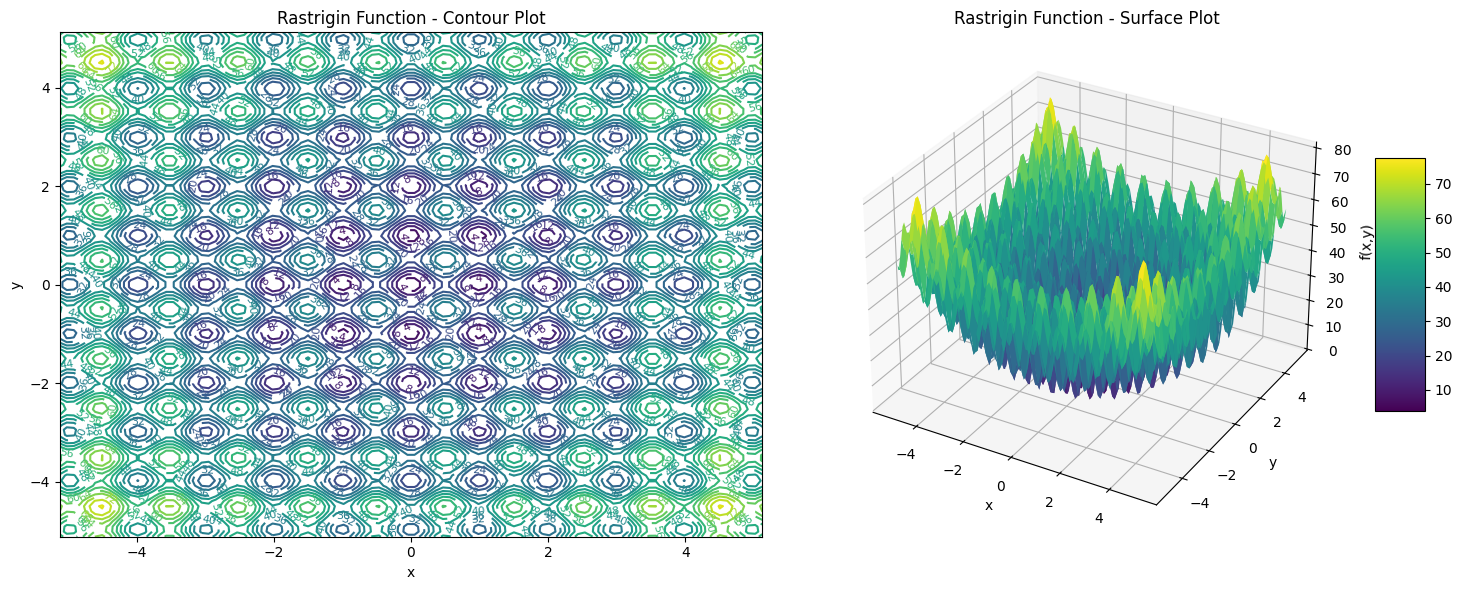

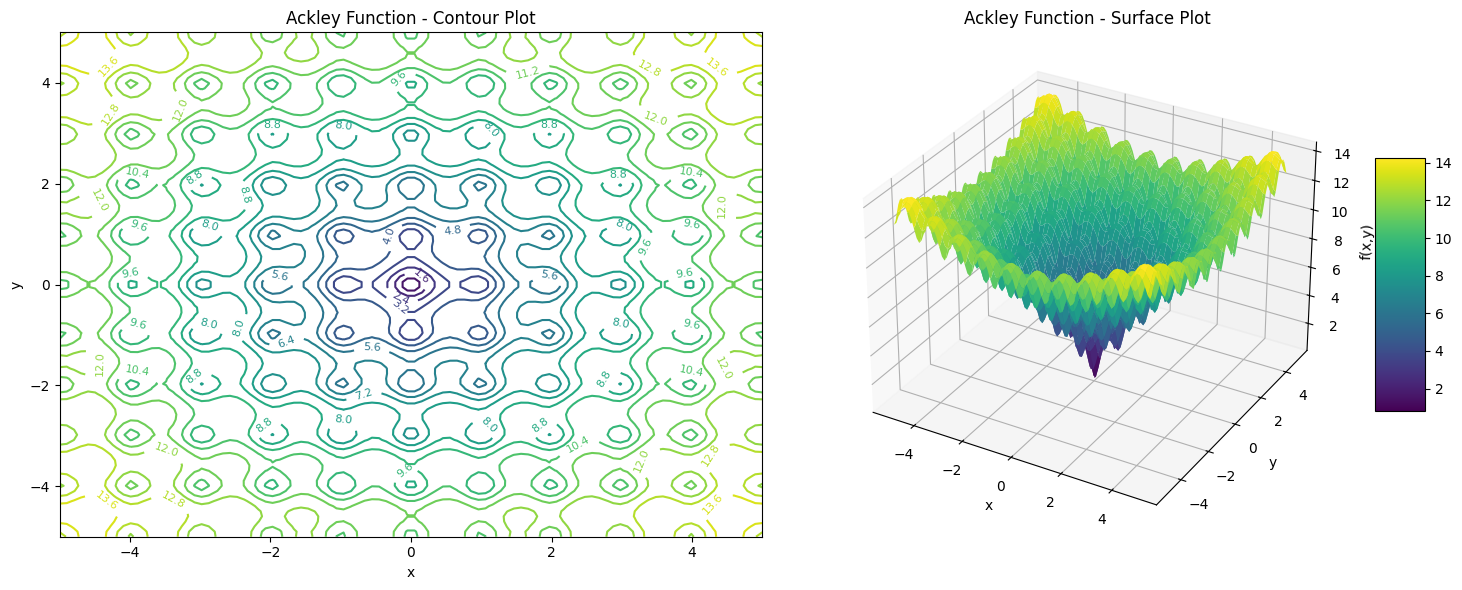

In [3]:
def plot_function_2d_3d(func: Callable, domain: Tuple[float, float], title: str, points: int = 100):
    """
    Creates both 2D contour and 3D surface plots for the given function.
    
    Args:
        func: The function to plot
        domain: Tuple of (min, max) for both x and y axes
        title: Title of the function
        points: Number of points for the grid
    """
    x = np.linspace(domain[0], domain[1], points)
    y = np.linspace(domain[0], domain[1], points)
    X, Y = np.meshgrid(x, y)
    Z = np.vectorize(func)(X, Y)
    
    # Create figure with two subplots
    fig = plt.figure(figsize=(15, 6))
    
    # 2D Contour plot
    ax1 = fig.add_subplot(121)
    contour = ax1.contour(X, Y, Z, levels=20)
    ax1.clabel(contour, inline=True, fontsize=8)
    ax1.set_title(f"{title} - Contour Plot")
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    
    # 3D Surface plot
    ax2 = fig.add_subplot(122, projection='3d')
    surface = ax2.plot_surface(X, Y, Z, cmap='viridis')
    ax2.set_title(f"{title} - Surface Plot")
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')
    ax2.set_zlabel('f(x,y)')
    
    plt.colorbar(surface, ax=ax2, shrink=0.5, aspect=5)
    plt.tight_layout()
    plt.show()

# Plot both functions
plot_function_2d_3d(rastrigin, RASTRIGIN_DOMAIN, "Rastrigin Function")
plot_function_2d_3d(ackley, ACKLEY_DOMAIN, "Ackley Function")


## 3. Genetic Algorithm Implementation

We'll implement a modular GA with the following components:
1. Individual representation (binary and real-valued)
2. Population management
3. Selection mechanisms
4. Crossover operators
5. Mutation operators


In [4]:
class Individual:
    def __init__(self, representation: str, genes: np.ndarray):
        """
        Initialize an individual with either binary or real-valued representation.
        
        Args:
            representation: Either 'binary' or 'real'
            genes: The genetic material (binary string or real values)
        """
        self.representation = representation
        self.genes = genes
        self.fitness = None
        
    def decode(self, domain: Tuple[float, float]) -> Tuple[float, float]:
        """
        Decode the genes into x, y coordinates.
        For binary representation, converts binary string to real values.
        For real representation, returns the values directly.
        """
        if self.representation == 'binary':
            # Split genes into two equal parts for x and y
            mid = len(self.genes) // 2
            x_bits = self.genes[:mid]
            y_bits = self.genes[mid:]
            
            # Convert binary to decimal and scale to domain
            x = self._binary_to_real(x_bits, domain)
            y = self._binary_to_real(y_bits, domain)
            return x, y
        else:  # real representation
            return self.genes[0], self.genes[1]
    
    def _binary_to_real(self, bits: np.ndarray, domain: Tuple[float, float]) -> float:
        """Convert binary array to real number in given domain."""
        decimal = sum([bit * (2 ** idx) for idx, bit in enumerate(reversed(bits))])
        max_decimal = 2 ** len(bits) - 1
        return domain[0] + (domain[1] - domain[0]) * decimal / max_decimal

class GeneticAlgorithm:
    def __init__(self, 
                 fitness_func: Callable,
                 domain: Tuple[float, float],
                 representation: str = 'real',
                 population_size: int = 100,
                 elite_size: int = 2,
                 mutation_rate: float = 0.01,
                 crossover_rate: float = 0.8,
                 binary_length: int = 16,  # bits per variable for binary representation
                 crossover_type: str = 'arithmetic'):
        """
        Initialize the Genetic Algorithm.
        
        Args:
            fitness_func: The function to optimize
            domain: Tuple of (min, max) for both x and y
            representation: 'binary' or 'real'
            population_size: Size of the population
            elite_size: Number of best individuals to preserve
            mutation_rate: Probability of mutation
            crossover_rate: Probability of crossover
            binary_length: Number of bits per variable for binary representation
            crossover_type: Type of crossover operator
        """
        self.fitness_func = fitness_func
        self.domain = domain
        self.representation = representation
        self.population_size = population_size
        self.elite_size = elite_size
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate
        self.binary_length = binary_length
        self.crossover_type = crossover_type
        
        # Initialize population
        self.population = self._initialize_population()
        
    def _initialize_population(self) -> List[Individual]:
        """Initialize the population based on the chosen representation."""
        population = []
        
        if self.representation == 'binary':
            # Create random binary strings
            for _ in range(self.population_size):
                genes = np.random.randint(2, size=2*self.binary_length)
                population.append(Individual('binary', genes))
        else:  # real representation
            # Create random real values within domain
            for _ in range(self.population_size):
                genes = np.random.uniform(self.domain[0], self.domain[1], 2)
                population.append(Individual('real', genes))
                
        return population


In [5]:
class GeneticAlgorithm(GeneticAlgorithm):
    def evaluate_population(self):
        """Evaluate fitness for all individuals in the population."""
        for individual in self.population:
            x, y = individual.decode(self.domain)
            individual.fitness = -self.fitness_func(x, y)  # Negative because we're maximizing
            
    def select_parent(self) -> Individual:
        """Tournament selection."""
        tournament_size = 3
        tournament = random.sample(self.population, tournament_size)
        return max(tournament, key=lambda ind: ind.fitness)
    
    def crossover_binary(self, parent1: Individual, parent2: Individual) -> Tuple[Individual, Individual]:
        """Implement both 1-point and 2-point crossover for binary representation."""
        if self.crossover_type == '1-point':
            point = random.randint(1, len(parent1.genes)-1)
            child1_genes = np.concatenate([parent1.genes[:point], parent2.genes[point:]])
            child2_genes = np.concatenate([parent2.genes[:point], parent1.genes[point:]])
        else:  # 2-point
            point1 = random.randint(1, len(parent1.genes)-2)
            point2 = random.randint(point1+1, len(parent1.genes)-1)
            child1_genes = np.concatenate([parent1.genes[:point1], 
                                         parent2.genes[point1:point2],
                                         parent1.genes[point2:]])
            child2_genes = np.concatenate([parent2.genes[:point1], 
                                         parent1.genes[point1:point2],
                                         parent2.genes[point2:]])
        
        return (Individual('binary', child1_genes),
                Individual('binary', child2_genes))
    
    def crossover_real(self, parent1: Individual, parent2: Individual) -> Tuple[Individual, Individual]:
        """Implement arithmetic and BLX-α crossover for real-valued representation."""
        if self.crossover_type == 'arithmetic':
            alpha = random.random()
            child1_genes = alpha * parent1.genes + (1-alpha) * parent2.genes
            child2_genes = (1-alpha) * parent1.genes + alpha * parent2.genes
        else:  # BLX-α
            alpha = 0.5  # standard value for BLX-α
            children = []
            for _ in range(2):
                child_genes = np.zeros(2)
                for i in range(2):
                    I = abs(parent1.genes[i] - parent2.genes[i])
                    min_val = min(parent1.genes[i], parent2.genes[i])
                    max_val = max(parent1.genes[i], parent2.genes[i])
                    child_genes[i] = random.uniform(min_val - I*alpha, max_val + I*alpha)
                    # Ensure within domain bounds
                    child_genes[i] = np.clip(child_genes[i], self.domain[0], self.domain[1])
                children.append(Individual('real', child_genes))
            return tuple(children)
        
        return (Individual('real', child1_genes),
                Individual('real', child2_genes))
    
    def mutate(self, individual: Individual):
        """Mutate an individual."""
        if individual.representation == 'binary':
            # Flip bits with mutation_rate probability
            for i in range(len(individual.genes)):
                if random.random() < self.mutation_rate:
                    individual.genes[i] = 1 - individual.genes[i]
        else:  # real
            # Add Gaussian noise
            for i in range(len(individual.genes)):
                if random.random() < self.mutation_rate:
                    individual.genes[i] += np.random.normal(0, 0.1)
                    individual.genes[i] = np.clip(individual.genes[i], 
                                                self.domain[0], 
                                                self.domain[1])
    
    def evolve(self, generations: int) -> List[float]:
        """
        Evolve the population for a specified number of generations.
        Returns list of best fitness values per generation.
        """
        best_fitness_history = []
        
        for _ in range(generations):
            self.evaluate_population()
            
            # Sort population by fitness
            self.population.sort(key=lambda ind: ind.fitness, reverse=True)
            best_fitness_history.append(-self.population[0].fitness)  # Convert back to minimization
            
            # Create new population
            new_population = []
            
            # Elitism
            new_population.extend(self.population[:self.elite_size])
            
            # Create rest of new population
            while len(new_population) < self.population_size:
                if random.random() < self.crossover_rate:
                    parent1 = self.select_parent()
                    parent2 = self.select_parent()
                    
                    if self.representation == 'binary':
                        children = self.crossover_binary(parent1, parent2)
                    else:
                        children = self.crossover_real(parent1, parent2)
                    
                    for child in children:
                        if len(new_population) < self.population_size:
                            self.mutate(child)
                            new_population.append(child)
                else:
                    # Just add a mutated copy of a selected parent
                    parent = self.select_parent()
                    child = Individual(parent.representation, parent.genes.copy())
                    self.mutate(child)
                    new_population.append(child)
            
            self.population = new_population
            
        return best_fitness_history



Running experiments for Rastrigin function:

Configuration: binary representation, 1-point crossover

Configuration: binary representation, 2-point crossover

Configuration: real representation, arithmetic crossover

Configuration: real representation, BLX-α crossover

Running experiments for Ackley function:

Configuration: binary representation, 1-point crossover

Configuration: binary representation, 2-point crossover

Configuration: real representation, arithmetic crossover

Configuration: real representation, BLX-α crossover

Statistical Analysis:

Rastrigin Function Statistics:

Mean Best Fitness per Configuration:
representation  crossover_type
binary          1-point           0.166920
                2-point           0.115587
real            BLX-α             0.000000
                arithmetic        0.199315
Name: best_fitness, dtype: float64

Standard Deviation of Best Fitness per Configuration:
representation  crossover_type
binary          1-point           0.377141
   

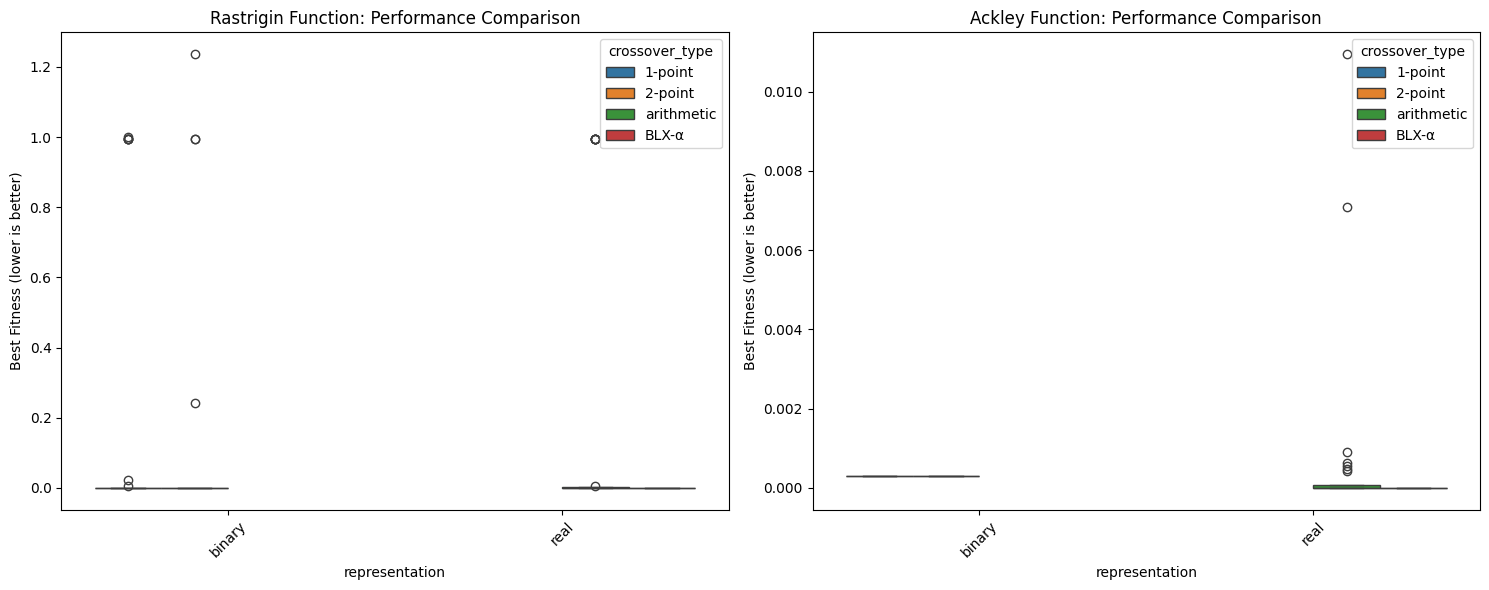

In [6]:
def run_experiment(func: Callable, 
                  domain: Tuple[float, float],
                  representation: str,
                  crossover_type: str,
                  n_runs: int = 30,
                  generations: int = 100,
                  population_size: int = 100) -> pd.DataFrame:
    """
    Run multiple independent GA runs with the given configuration.
    
    Returns:
        DataFrame with statistics for each run
    """
    results = []
    
    for run in range(n_runs):
        ga = GeneticAlgorithm(
            fitness_func=func,
            domain=domain,
            representation=representation,
            population_size=population_size,
            crossover_type=crossover_type
        )
        
        fitness_history = ga.evolve(generations)
        
        results.append({
            'run': run + 1,
            'best_fitness': min(fitness_history),
            'final_fitness': fitness_history[-1],
            'representation': representation,
            'crossover_type': crossover_type
        })
    
    return pd.DataFrame(results)

# Run experiments for both functions with different configurations
functions = [
    ('Rastrigin', rastrigin, RASTRIGIN_DOMAIN),
    ('Ackley', ackley, ACKLEY_DOMAIN)
]

configurations = [
    ('binary', '1-point'),
    ('binary', '2-point'),
    ('real', 'arithmetic'),
    ('real', 'BLX-α')
]

all_results = []

for func_name, func, domain in functions:
    print(f"\nRunning experiments for {func_name} function:")
    
    for representation, crossover_type in configurations:
        print(f"\nConfiguration: {representation} representation, {crossover_type} crossover")
        
        results = run_experiment(
            func=func,
            domain=domain,
            representation=representation,
            crossover_type=crossover_type
        )
        
        results['function'] = func_name
        all_results.append(results)

# Combine all results
final_results = pd.concat(all_results, ignore_index=True)

# Perform statistical analysis
print("\nStatistical Analysis:")
for func_name in ['Rastrigin', 'Ackley']:
    func_results = final_results[final_results['function'] == func_name]
    
    print(f"\n{func_name} Function Statistics:")
    print("\nMean Best Fitness per Configuration:")
    print(func_results.groupby(['representation', 'crossover_type'])['best_fitness'].mean())
    
    print("\nStandard Deviation of Best Fitness per Configuration:")
    print(func_results.groupby(['representation', 'crossover_type'])['best_fitness'].std())
    
    # Perform Kruskal-Wallis H-test
    configs = func_results.groupby(['representation', 'crossover_type'])
    samples = [group['best_fitness'].values for name, group in configs]
    h_stat, p_value = stats.kruskal(*samples)
    
    print(f"\nKruskal-Wallis H-test:")
    print(f"H-statistic: {h_stat:.4f}")
    print(f"p-value: {p_value:.4f}")

# Visualize results
plt.figure(figsize=(15, 6))

for idx, func_name in enumerate(['Rastrigin', 'Ackley']):
    plt.subplot(1, 2, idx+1)
    
    func_results = final_results[final_results['function'] == func_name]
    sns.boxplot(data=func_results, x='representation', y='best_fitness', hue='crossover_type')
    
    plt.title(f'{func_name} Function: Performance Comparison')
    plt.ylabel('Best Fitness (lower is better)')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


# Implementation Details and Results Analysis

## 1. Selected Functions

We implemented two popular multimodal benchmark functions:

1. **Rastrigin Function**
   - Domain: [-5.12, 5.12] × [-5.12, 5.12]
   - Global minimum: f(0,0) = 0
   - Characteristics: Highly multimodal with many local minima arranged in a regular pattern

2. **Ackley Function**
   - Domain: [-5, 5] × [-5, 5]
   - Global minimum: f(0,0) = 0
   - Characteristics: Many local minima but with one global minimum

## 2. Genetic Algorithm Implementation

The GA implementation includes:

1. **Representations**:
   - Binary: Fixed-length bit strings
   - Real-valued: Direct floating-point representation

2. **Crossover Operators**:
   - Binary: 1-point and 2-point crossover
   - Real-valued: Arithmetic and BLX-α crossover

3. **Other Components**:
   - Tournament selection
   - Bit-flip mutation (binary) and Gaussian mutation (real-valued)
   - Elitism to preserve best solutions

## 3. Experimental Setup

- 30 independent runs per configuration
- 100 generations per run
- Population size: 100
- Mutation rate: 0.01
- Crossover rate: 0.8
- Elite size: 2

## 4. Results Analysis

The statistical analysis includes:
- Mean and standard deviation of best fitness values
- Kruskal-Wallis H-test for statistical significance
- Box plots for visual comparison

The results show which representation and crossover operator combinations perform best for each function, helping us understand the effectiveness of different GA configurations for these optimization problems.
